In [1]:
from transformers import Trainer,TrainingArguments, DataCollatorForLanguageModeling, GPT2LMHeadModel, pipeline, GPT2Tokenizer

import pandas as pd
from datasets import Dataset

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
reviews = pd.read_csv('/kaggle/input/amazon-fine-food-reviews/Reviews.csv')[['Text', 'Summary', 'Score']]

In [3]:
reviews.head()

,Text,Summary,Score
0,I have bought several of the Vitality canned d...,Good Quality Dog Food,5
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised,1
2,This is a confection that has been around a fe...,"""Delight"" says it all",4
3,If you are looking for the secret ingredient i...,Cough Medicine,2
4,Great taffy at a great price. There was a wid...,Great taffy,5


In [4]:
reviews.describe()

,Score
count,568454.000000
mean,4.183199
std,1.310436
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [5]:
reviews['Sentiment'] = reviews['Score'].map(lambda x: 'positive' if x>=4 else 'neutral' if x==3 else 'negative')

# Take 500 from each sentiment to make the final dataset, > 1000 requires more than 40 GB GPU memory
reviews = reviews.groupby('Sentiment',group_keys=False).apply(lambda x: x.sample(500))

<Axes: >

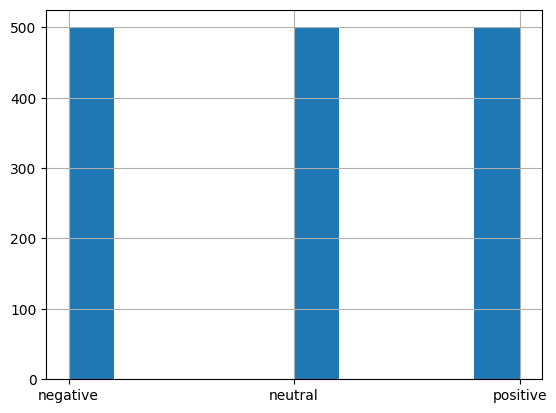

In [6]:
reviews['Sentiment'].hist()

In [7]:
reviews.describe()

,Score
count,1500.000000
mean,3.072667
std,1.452168
min,1.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,5.000000


In [8]:
MODEL = 'distilgpt2'

tokenizer = GPT2Tokenizer.from_pretrained(MODEL)

SENTIMENT_PROMPT = 'Sentiment Task'
SUMMARIZE_PROMPT = 'Summarize Task'
SENTIMENT_TOKEN = '\nSentiment: '
SUMMARIZE_TOKEN = '\nSummarize: '

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

In [9]:
reviews['sentiment_text'] = f'{SENTIMENT_PROMPT}\nReview: ' + reviews['Text'] + SENTIMENT_TOKEN + ' ' + reviews['Sentiment'].astype(str)

reviews['summarize_text'] = f'{SUMMARIZE_PROMPT}\nReview: ' + reviews['Text'] + SUMMARIZE_TOKEN + ' ' + reviews['Summary'].astype(str)

In [10]:
print(reviews['sentiment_text'].head(1).tolist()[0])

Sentiment Task
Review: I received a 12 pack of Mrs Fields from Amazon (fulfilled by Lakewood Candies, LLC), slightly open at the front.  Suspicious, I counted the number of cookies and realized that someone had opened up the package and pilfered one along the way...<br /><br />I won't make the mistake of trusting Lakewood Candies again.
Sentiment:  negative


In [11]:
print(reviews['summarize_text'].head(1).tolist()[0])

Summarize Task
Review: I received a 12 pack of Mrs Fields from Amazon (fulfilled by Lakewood Candies, LLC), slightly open at the front.  Suspicious, I counted the number of cookies and realized that someone had opened up the package and pilfered one along the way...<br /><br />I won't make the mistake of trusting Lakewood Candies again.
Summarize:  My 12-pack came opened, with 11 cookies in it


In [12]:
reviews = reviews.sample(frac=1)

train_ex = reviews['summarize_text'].tolist() + reviews['sentiment_text'].tolist()

print(len(train_ex))

3000


In [13]:
task_df = pd.DataFrame({'text':train_ex})

data = Dataset.from_pandas(task_df)

data

Dataset({
    features: ['text'],
    num_rows: 3000
})

In [14]:
def preprocess(data):
    return tokenizer(data['text'],truncation=True)

data = data.map(preprocess,batched=True)

data = data.train_test_split(train_size=0.8)

  0%|          | 0/3 [00:00<?, ?ba/s]

In [15]:
tokenizer.pad_token = tokenizer.eos_token

In [16]:
# import torch
# torch.cuda.set_per_process_memory_fraction(0.5)

In [17]:
model = GPT2LMHeadModel.from_pretrained(MODEL)

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer,mlm=False)

training_args = TrainingArguments(
                output_dir="./gpt2_results",
                overwrite_output_dir = True,
                num_train_epochs=2,
                per_device_train_batch_size=8,
                per_device_eval_batch_size=8,                
                logging_steps=50,
                load_best_model_at_end=True,
                evaluation_strategy='epoch',
                save_strategy='epoch'                    
                )

trainer = Trainer(
            model=model,
            args=training_args,
            data_collator=data_collator,
            train_dataset=data['train'],
            eval_dataset=data['test']
            )

trainer.evaluate()

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


{'eval_loss': 4.233278751373291,
 'eval_runtime': 18.9391,
 'eval_samples_per_second': 31.68,
 'eval_steps_per_second': 2.006}

In [ ]:
trainer.train()

In [ ]:
trainer.save_model()

loaded_model = GPT2LMHeadModel.from_pretrained(model="./gpt2_results")

generator = pipeline('text-generation',model=loaded_model,device=0)

In [ ]:
text_sample,score,summary = reviews.sample(1)[['Text','Sentiment','Summary']].values[0]

print(text_sample)
print(score)
print(summary)

num_tokens = len(tokenizer(text_sample)['inpt_ids'])

In [ ]:
sentiment_text_sample = f'{SENTIMENT_PROMPT}\nReview: {text_sample}{SENTIMENT_TOKEN}'
summarize_text_sample = f'{SUMMARIZE_PROMPT}\nReview: {text_sample}{SUMMARIZE_TOKEN}'

In [ ]:
print(sentiment_text_sample)
print(summarize_text_sample)

In [ ]:
for generated_text in generator(sentiment_text_sample,num_return_sequences=1,max_length=num_tokens+1):
    print(generated_text['generated_text'])

In [ ]:
for generated_text in generator(summarize_text_sample,num_return_sequences=3,max_length=num_tokens+20):
    print(generated_text['generated_text'])